In [1]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Reference: https://github.com/Kfirco12/Phishing-URL-Detection

### Data + Features Preparation

In [2]:
from urllib.parse import urlparse
from collections import Counter

CHARS = ['.','-','_','=','/','?',';','(',')','%','&','@']
SUSPICIOUS_WORDS = ["secure", "account", "webscr", "login", "ebayisapi", "signin", "banking",\
    "confirm", "blog", "logon", "signon", "login.asp", "login.php", "login.htm", \
    ".exe", ".zip", ".rar", ".jpg", ".gif", "viewer.php", "link=", "getImage.asp", \
    "plugins", "paypal", "order", "dbsys.php", "config.bin", "download.php", ".js", \
    "payment", "files", "css", "shopping", "mail.php", ".jar", ".swf", ".cgi", ".php",\
    "abuse", "admin", ".bin", "personal", "update", "verification"]

COLS = ["url_len", "query_len", "digit_count", "token_count"]
COLS_CHAR = ["dots_num", "hyphens_num", "underscore_num", "equal_num", \
    "f_slash_num", "q_mark_num", "semicolon_num", "o_parenthesis_num", \
    "c_parenthesis_num", "mod_num", "amp_num", "at_num"]

get_url_len = lambda x: len(x) # URL length
get_query_len = lambda x: len(urlparse(x).query)
count_digit = lambda x: sum(c.isdigit() for c in x)
count_token = lambda x: x.count('token=')

def count_char(x):
    counter = Counter(x)
    return [counter[c] for c in CHARS]

def count_sus(x):
    exist_list = []
    for word in SUSPICIOUS_WORDS:
        exist_list.append(True if word in x else False)
    return exist_list

def get_features(url, label):
    features = []
    
    features.append(get_url_len(url))
    features.append(get_query_len(url))
    features.append(count_digit(url))
    features.append(count_token(url))
    
    features.extend(count_char(url))
    features.extend(count_sus(url))
    
    features.append(label)
    return features

In [4]:
data = pd.read_csv('../data/URL_data.csv').drop(['score'], axis=1)

data_featurized = []
for i in range(len(data)):
    features = get_features(data["url"][i], data["label"][i])
    data_featurized.append(features)

columns = COLS + COLS_CHAR+SUSPICIOUS_WORDS+['label']
data_df = pd.DataFrame(data_featurized, columns=columns)

### Random Forest Model

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Grab X, y datasets
X, y = data_df.drop(['label'], axis=1).values, data_df['label'].values.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Random Forest Model
model = RandomForestClassifier(n_estimators=10)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [6]:
# Accuracy
score = model.score(X_test, y_test)
print(score)

0.9273403806867927


In [7]:
# Save Model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [8]:
# Ensure pickle file works
with open('model.pkl', 'rb') as f:
    clf = pickle.load(f)
clf.predict(X[0:1])

array([-1])

### Random Forest Model Visualization

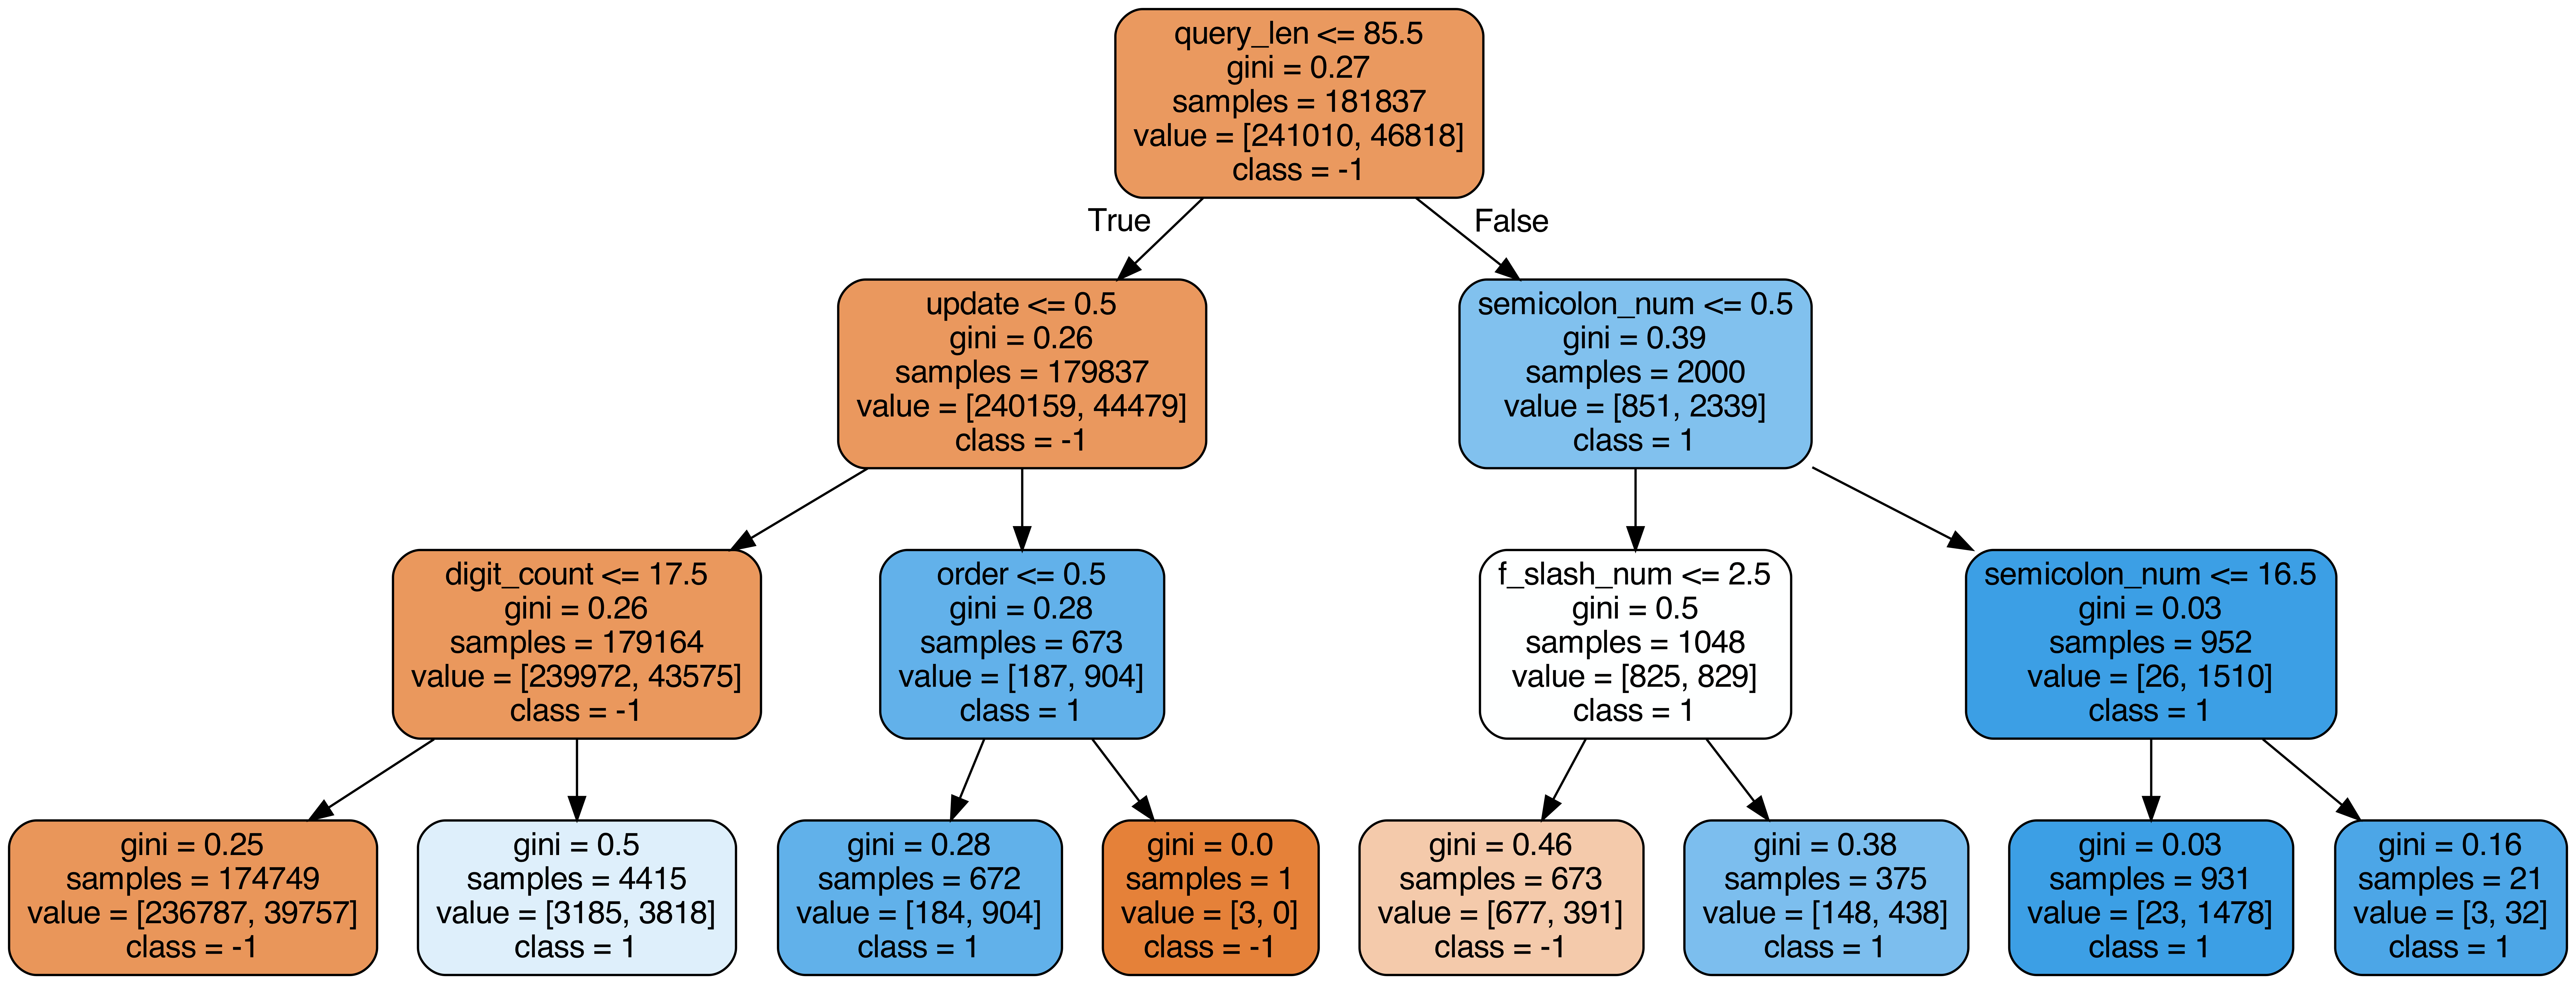

In [25]:
# Reference: https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
from sklearn.tree import export_graphviz

mdl = RandomForestClassifier(n_estimators=10, max_depth=3)
mdl.fit(X_train, y_train)
estimator = mdl.estimators_[5]

export_graphviz(estimator, out_file='visuals/tree.dot', feature_names=columns[:-1], class_names=["-1", "1"], \
                rounded=True, proportion=False, precision=2, filled=True)

from subprocess import call
call(['dot', '-Tpng', 'visuals/tree.dot', '-o', 'visuals/tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'visuals/tree.png')